In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import mstats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

C:\Users\Gebruiker\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_excel('Final dataset for real3.xlsx', index_col = 0)
data = data.reset_index()

In [3]:
data.count()

Company name           21233
Country ISO code       21233
Nr. of Tax Treaties    21233
NACE Rev. 2            21170
Operating revenue      19609
Number of employees    13013
PBT                    21233
Total assets           21224
ROA                    19716
No of subsidiaries     21233
Solvency ratio         20407
Long term debt         18793
Debtors                21121
Current liabilities    21132
Size                   21233
Accounting practice    21233
Degree                 18639
Closeness              18639
Betweenness            18639
Eigenvector            18639
Hubs                   18639
ETR                    21233
dtype: int64

In [23]:
data['Country ISO code'] = data['Country ISO code'].astype('category')
data['Size'] = data['Size'].astype('category')
data['Accounting practice'] = data['Accounting practice'].astype('category')
data['NACE Rev. 2'] = data['NACE Rev. 2'].astype('category')

X = data[["Nr. of Tax Treaties","NACE Rev. 2","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities", "Size","Accounting practice","Degree","Closeness","Betweenness","Eigenvector"]]
y = data["ETR"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 2031996, shuffle = True)

X_train_con = X_train[["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]]
X_train_na = X_train[["Degree", "Closeness", "Betweenness", "Eigenvector"]]
X_train_cat = X_train[['NACE Rev. 2', 'Size', 'Accounting practice']]

scaler_con = StandardScaler()
scaler_con.fit(X_train_con)
scaler_na = StandardScaler()
scaler_na.fit(X_train_na)
StandardScaler()
X_train_con = scaler_con.transform(X_train_con)

X_train_na = pd.DataFrame(scaler_na.transform(X_train_na), index = X_train.index)
X_train_na.columns = ["Degree", "Closeness", "Betweenness", "Eigenvector"]

iim=IterativeImputer(
initial_strategy='median',
max_iter=10,
missing_values= np.nan,
random_state=2031996)

imputed_X_train_con = pd.DataFrame(iim.fit_transform(X_train_con), index = X_train.index)
imputed_X_train_con.columns = ["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]
imputed_X_train_cat = pd.get_dummies(X_train_cat)

drop_na = pd.concat([imputed_X_train_con, imputed_X_train_cat, X_train_na, y_train], axis = 1)
drop_na = drop_na.dropna()
drop_na = pd.DataFrame(drop_na)

X_train_final = drop_na.loc[:,:"Eigenvector"]
y_train_final = drop_na['ETR']

X_test_con = X_test[["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]]
X_test_na = X_test[["Degree", "Closeness", "Betweenness", "Eigenvector"]]
X_test_cat = X_test[['NACE Rev. 2', 'Size', 'Accounting practice']]

X_test_con = scaler_con.transform(X_test_con)

X_test_na = pd.DataFrame(scaler_na.transform(X_test_na), index = X_test.index)
X_test_na.columns = ["Degree", "Closeness", "Betweenness", "Eigenvector"]

imputed_X_test_con = pd.DataFrame(iim.transform(X_test_con), index = X_test.index)
imputed_X_test_con.columns = ["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]
imputed_X_test_cat = pd.get_dummies(X_test_cat)

drop_na = pd.concat([imputed_X_test_con, imputed_X_test_cat, X_test_na, y_test], axis = 1)
drop_na = drop_na.dropna()
drop_na = pd.DataFrame(drop_na)

X_test_final = drop_na.loc[:,:"Eigenvector"]
y_test_final = drop_na['ETR']

print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)
print('Imputed' , X_train_final.shape, y_train_final.shape)
print('Imputed_test' , X_test_final.shape, y_test_final.shape)

Train (16986, 18) (16986,)
Test (4247, 18) (4247,)
Imputed (14904, 33) (14904,)
Imputed_test (3735, 33) (3735,)


In [24]:
def winsorize(dataframe, upper, lower, column_to_winsor):
    dataframe = dataframe.sort_values(column_to_winsor, ascending=False, ignore_index = True)
    amount = dataframe[column_to_winsor].count()
    up = int(amount * (upper/100))
    low = int(amount * (lower/100))
    data_winsor = dataframe.loc[low:up]
    return data_winsor

data_winsor = winsorize(data, 99,  1, 'ETR') 
data_winsor = winsorize(data_winsor, 99, 1, "Operating revenue")
data_winsor = winsorize(data_winsor, 99, 1, "Total assets")
data_winsor = winsorize(data_winsor, 99, 1, "Current liabilities")
data_winsor = winsorize(data_winsor, 99, 1, "Betweenness")
data_winsor = winsorize(data_winsor, 99, 1, "Long term debt")
data_winsor = winsorize(data_winsor, 99, 1, "PBT")

X_winsor = data_winsor[["Nr. of Tax Treaties","NACE Rev. 2","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities", "Size","Accounting practice","Degree","Closeness","Betweenness","Eigenvector"]]
y_winsor = data_winsor["ETR"]

X_train_winsor, X_test_winsor, y_train_winsor, y_test_winsor = train_test_split(X_winsor, y_winsor, test_size=0.20, random_state= 2031996, shuffle = True)

X_train_con_winsor = X_train_winsor[["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]]
X_train_na_winsor = X_train_winsor[["Degree", "Closeness", "Betweenness", "Eigenvector"]]
X_train_cat_winsor = X_train_winsor[['NACE Rev. 2', 'Size', 'Accounting practice']]

scaler_con_winsor = StandardScaler()
scaler_con_winsor.fit(X_train_con_winsor)
scaler_na_winsor = StandardScaler()
scaler_na_winsor.fit(X_train_na_winsor)
StandardScaler()
X_train_con_winsor = scaler_con_winsor.transform(X_train_con_winsor)

X_train_na_winsor = pd.DataFrame(scaler_na_winsor.transform(X_train_na_winsor), index = X_train_winsor.index)
X_train_na_winsor.columns = ["Degree", "Closeness", "Betweenness", "Eigenvector"]

iim=IterativeImputer(
initial_strategy='median',
max_iter=10,
missing_values= np.nan,
random_state=2031996)

imputed_X_train_con_winsor = pd.DataFrame(iim.fit_transform(X_train_con_winsor), index = X_train_winsor.index)
imputed_X_train_con_winsor.columns = ["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]
imputed_X_train_cat_winsor = pd.get_dummies(X_train_cat_winsor)

drop_na_winsor = pd.concat([imputed_X_train_con_winsor, imputed_X_train_cat_winsor, X_train_na_winsor, y_train_winsor], axis = 1)
drop_na_winsor = drop_na_winsor.dropna()
drop_na_winsor = pd.DataFrame(drop_na_winsor)

X_train_final_winsor = drop_na_winsor.loc[:,:'Eigenvector']
y_train_final_winsor = drop_na_winsor['ETR']

X_test_con_winsor = X_test_winsor[["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]]
X_test_na_winsor = X_test_winsor[["Degree", "Closeness", "Betweenness", "Eigenvector"]]
X_test_cat_winsor = X_test_winsor[['NACE Rev. 2', 'Size', 'Accounting practice']]

X_test_con_winsor = scaler_con_winsor.transform(X_test_con_winsor)

X_test_na_winsor = pd.DataFrame(scaler_na_winsor.transform(X_test_na_winsor), index = X_test_winsor.index)
X_test_na_winsor.columns = ["Degree", "Closeness", "Betweenness", "Eigenvector"]

imputed_X_test_con_winsor = pd.DataFrame(iim.transform(X_test_con_winsor), index = X_test_winsor.index)
imputed_X_test_con_winsor.columns = ["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]
imputed_X_test_cat_winsor = pd.get_dummies(X_test_cat_winsor)

drop_na_winsor = pd.concat([imputed_X_test_con_winsor, imputed_X_test_cat_winsor, X_test_na_winsor, y_test_winsor], axis = 1)
drop_na_winsor = pd.DataFrame(drop_na_winsor)

X_test_final_winsor = drop_na_winsor.loc[:,:'Eigenvector']
y_test_final_winsor = drop_na_winsor['ETR']

print('Train', X_train_winsor.shape, y_train_winsor.shape)
print('Test', X_test_winsor.shape, y_test_winsor.shape)
print('Imputed' , X_train_final_winsor.shape, y_train_final_winsor.shape)
print('Imputed' , X_test_final_winsor.shape, y_test_final_winsor.shape)

Train (11108, 18) (11108,)
Test (2778, 18) (2778,)
Imputed (11108, 33) (11108,)
Imputed (2778, 33) (2778,)


In [25]:
def winsorize(dataframe, upper, lower, column_to_winsor):
    dataframe = dataframe.sort_values(column_to_winsor, ascending=False, ignore_index = True)
    amount = dataframe[column_to_winsor].count()
    up = int(amount * (upper/100))
    low = int(amount * (lower/100))
    data_winsor = dataframe.loc[low:up]
    return data_winsor

data_winsor2 = winsorize(data, 97.5,  4, 'ETR') 
data_winsor2 = winsorize(data_winsor2, 100,  4, "Operating revenue")
data_winsor2 = winsorize(data_winsor2, 100,  4, "Total assets")
data_winsor2 = winsorize(data_winsor2, 100,  4, "Current liabilities")
data_winsor2 = winsorize(data_winsor2, 100,  4, "Betweenness")
data_winsor2 = winsorize(data_winsor2, 100,  4, "Long term debt")
data_winsor2 = winsorize(data_winsor2, 97.5,  2.5, "PBT")

X_winsor2 = data_winsor2[["Nr. of Tax Treaties","NACE Rev. 2","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities", "Size","Accounting practice","Degree","Closeness","Betweenness","Eigenvector"]]
y_winsor2 = data_winsor2["ETR"]

X_train_winsor2, X_test_winsor2, y_train_winsor2, y_test_winsor2 = train_test_split(X_winsor2, y_winsor2, test_size=0.20, random_state= 2031996, shuffle = True)

X_train_con_winsor2 = X_train_winsor2[["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]]
X_train_na_winsor2 = X_train_winsor2[["Degree", "Closeness", "Betweenness", "Eigenvector"]]
X_train_cat_winsor2 = X_train_winsor2[['NACE Rev. 2', 'Size', 'Accounting practice']]

scaler_con_winsor2 = StandardScaler()
scaler_con_winsor2.fit(X_train_con_winsor2)
scaler_na_winsor2 = StandardScaler()
scaler_na_winsor2.fit(X_train_na_winsor2)
StandardScaler()
X_train_con_winsor2 = scaler_con_winsor2.transform(X_train_con_winsor2)

X_train_na_winsor2 = pd.DataFrame(scaler_na_winsor2.transform(X_train_na_winsor2), index = X_train_winsor2.index)
X_train_na_winsor2.columns = ["Degree", "Closeness", "Betweenness", "Eigenvector"]

iim=IterativeImputer(
initial_strategy='median',
max_iter=10,
missing_values= np.nan,
random_state=2031996)

imputed_X_train_con_winsor2 = pd.DataFrame(iim.fit_transform(X_train_con_winsor2), index = X_train_winsor2.index)
imputed_X_train_con_winsor2.columns = ["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]
imputed_X_train_cat_winsor2 = pd.get_dummies(X_train_cat_winsor2)

drop_na_winsor2 = pd.concat([imputed_X_train_con_winsor2, imputed_X_train_cat_winsor2, X_train_na_winsor2, y_train_winsor2], axis = 1)
drop_na_winsor2 = drop_na_winsor2.dropna()
drop_na_winsor2 = pd.DataFrame(drop_na_winsor2)

X_train_final_winsor2 = drop_na_winsor2.loc[:,:'Eigenvector']
y_train_final_winsor2 = drop_na_winsor2['ETR']

X_test_con_winsor2 = X_test_winsor2[["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]]
X_test_na_winsor2 = X_test_winsor2[["Degree", "Closeness", "Betweenness", "Eigenvector"]]
X_test_cat_winsor2 = X_test_winsor2[['NACE Rev. 2', 'Size', 'Accounting practice']]

X_test_con_winsor2 = scaler_con_winsor2.transform(X_test_con_winsor2)

X_test_na_winsor2 = pd.DataFrame(scaler_na_winsor2.transform(X_test_na_winsor2), index = X_test_winsor2.index)
X_test_na_winsor2.columns = ["Degree", "Closeness", "Betweenness", "Eigenvector"]

imputed_X_test_con_winsor2 = pd.DataFrame(iim.transform(X_test_con_winsor2), index = X_test_winsor2.index)
imputed_X_test_con_winsor2.columns = ["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]
imputed_X_test_cat_winsor2 = pd.get_dummies(X_test_cat_winsor2)

drop_na_winsor2 = pd.concat([imputed_X_test_con_winsor2, imputed_X_test_cat_winsor2, X_test_na_winsor2, y_test_winsor2], axis = 1)
drop_na_winsor2 = pd.DataFrame(drop_na_winsor2)

X_test_final_winsor2 = drop_na_winsor2.loc[:,:'Eigenvector']
y_test_final_winsor2 = drop_na_winsor2['ETR']

print('Train', X_train_winsor2.shape, y_train_winsor2.shape)
print('Test', X_test_winsor2.shape, y_test_winsor2.shape)
print('Imputed' , X_train_final_winsor2.shape, y_train_final_winsor2.shape)
print('Imputed' , X_test_final_winsor2.shape, y_test_final_winsor2.shape)

Train (8877, 18) (8877,)
Test (2220, 18) (2220,)
Imputed (8876, 33) (8876,)
Imputed (2220, 33) (2220,)


In [30]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
min_samples_split = [2, 20, 50]
min_samples_leaf = [1, 20, 80]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [34]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train_final, y_train_final)
best_parameters = rf_random.best_estimator_
print(best_parameters)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
RandomForestRegressor(max_depth=110, max_features='log2', min_samples_leaf=80,
                      min_samples_split=50, n_estimators=200)


In [35]:
rf_winsor = RandomForestRegressor()
rf_random_winsor = RandomizedSearchCV(estimator = rf_winsor, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random_winsor.fit(X_train_final_winsor, y_train_final_winsor)
best_parameters_winsor = rf_random_winsor.best_estimator_
print(best_parameters_winsor)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\Gebruiker\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomForestRegressor(n_estimators=1100)


In [36]:
rf_winsor2 = RandomForestRegressor()
rf_random_winsor2 = RandomizedSearchCV(estimator = rf_winsor2, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random_winsor2.fit(X_train_final_winsor2, y_train_final_winsor2)
best_parameters_winsor2 = rf_random_winsor2.best_estimator_
print(best_parameters_winsor2)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\Gebruiker\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomForestRegressor(max_depth=85, n_estimators=1550)


In [11]:
n_estimators = [int(x) for x in np.linspace(start = 580, stop = 590, num = 5)]
max_features = ['log2']
max_depth = [int(x) for x in np.linspace(3, 6, num = 3)]
max_depth.append(None)
min_samples_split = [200, 250, 280]
min_samples_leaf = [590, 600, 610]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train_final, y_train_final)
best_parameters = rf_random.best_estimator_
print(best_parameters)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestRegressor(bootstrap=False, max_depth=6, max_features='log2',
                      min_samples_leaf=600, min_samples_split=200,
                      n_estimators=580)


In [13]:
n_estimators = [int(x) for x in np.linspace(start = 700, stop = 750, num = 5)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(70, 80, num = 5)]
max_depth.append(None)
min_samples_split = [190, 200, 210]
min_samples_leaf = [595, 600, 605]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_winsor = RandomForestRegressor()
rf_random_winsor = RandomizedSearchCV(estimator = rf_winsor, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random_winsor.fit(X_train_final_winsor, y_train_final_winsor)
best_parameters_winsor = rf_random_winsor.best_estimator_
print(best_parameters_winsor)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestRegressor(bootstrap=False, max_depth=77, max_features='sqrt',
                      min_samples_leaf=595, min_samples_split=210,
                      n_estimators=737)


In [14]:
n_estimators = [int(x) for x in np.linspace(start = 400, stop = 550, num = 15)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(1, 20, num = 15)]
max_depth.append(None)
min_samples_split = [int(x) for x in np.linspace(400, 550, num = 15)]
min_samples_leaf = [int(x) for x in np.linspace(300, 400, num = 15)]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_winsor2 = RandomForestRegressor()
rf_random_winsor2 = RandomizedSearchCV(estimator = rf_winsor2, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random_winsor2.fit(X_train_final_winsor2, y_train_final_winsor2)
best_parameters_winsor2 = rf_random_winsor2.best_estimator_
print(best_parameters_winsor2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestRegressor(bootstrap=False, max_depth=11, max_features='sqrt',
                      min_samples_leaf=342, min_samples_split=421,
                      n_estimators=464)


In [37]:
rf_for_pred = RandomForestRegressor(max_depth=110, max_features='log2', min_samples_leaf=80,
                      min_samples_split=50, n_estimators=200)

rf_for_pred.fit(X_train_final,y_train_final)

y_pred = rf_for_pred.predict(X_test_final)

mae = mean_absolute_error(y_test_final, y_pred)
mse = mean_squared_error(y_test_final, y_pred)
rmse = np.sqrt(mse)
d_nonan = {'With outliers': [mse, rmse, mae]}
df_nonan = pd.DataFrame(d_nonan, index = ['MSE','RMSE','MAE'])
print(df_nonan)

      With outliers
MSE   150509.342077
RMSE     387.955335
MAE       77.111868


In [27]:
rf_for_pred_winsor = RandomForestRegressor(bootstrap=False, max_depth=60, max_features='sqrt',
                      n_estimators=650)

rf_for_pred_winsor.fit(X_train_final_winsor,y_train_final_winsor)

y_pred_winsor = rf_for_pred_winsor.predict(X_test_final_winsor)

mae_winsor = mean_absolute_error(y_test_final_winsor, y_pred_winsor)
mse_winsor = mean_squared_error(y_test_final_winsor, y_pred_winsor)
rmse_winsor = np.sqrt(mse_winsor)
d_nonan_winsor = {'1% outliers removed': [mse_winsor, rmse_winsor, mae_winsor]}
df_nonan_winsor = pd.DataFrame(d_nonan_winsor, index = ['MSE','RMSE','MAE'])
print(df_nonan_winsor)

      1% outliers removed
MSE            575.131973
RMSE            23.981909
MAE             12.673729


In [38]:
rf_for_pred_winsor = RandomForestRegressor(n_estimators=1100)

rf_for_pred_winsor.fit(X_train_final_winsor,y_train_final_winsor)

y_pred_winsor = rf_for_pred_winsor.predict(X_test_final_winsor)

mae_winsor = mean_absolute_error(y_test_final_winsor, y_pred_winsor)
mse_winsor = mean_squared_error(y_test_final_winsor, y_pred_winsor)
rmse_winsor = np.sqrt(mse_winsor)
d_nonan_winsor = {'1% outliers removed': [mse_winsor, rmse_winsor, mae_winsor]}
df_nonan_winsor = pd.DataFrame(d_nonan_winsor, index = ['MSE','RMSE','MAE'])
print(df_nonan_winsor)

      1% outliers removed
MSE            453.142449
RMSE            21.287143
MAE             11.779750


In [28]:
rf_for_pred_winsor2 = RandomForestRegressor(bootstrap=False, max_depth=60, max_features='sqrt',
                      n_estimators=650)

rf_for_pred_winsor2.fit(X_train_final_winsor2,y_train_final_winsor2)

y_pred_winsor2 = rf_for_pred_winsor2.predict(X_test_final_winsor2)

mae_winsor2 = mean_absolute_error(y_test_final_winsor2, y_pred_winsor2)
mse_winsor2 = mean_squared_error(y_test_final_winsor2, y_pred_winsor2)
rmse_winsor2 = np.sqrt(mse_winsor2)
d_nonan_winsor2 = {'5% outliers removed': [mse_winsor2, rmse_winsor2, mae_winsor2]}
df_nonan_winsor2 = pd.DataFrame(d_nonan_winsor2, index = ['MSE','RMSE','MAE'])
print(df_nonan_winsor2)

      5% outliers removed
MSE            175.211686
RMSE            13.236755
MAE              8.735834


In [39]:
rf_for_pred_winsor2 = RandomForestRegressor(max_depth=85, n_estimators=1550)

rf_for_pred_winsor2.fit(X_train_final_winsor2,y_train_final_winsor2)

y_pred_winsor2 = rf_for_pred_winsor2.predict(X_test_final_winsor2)

mae_winsor2 = mean_absolute_error(y_test_final_winsor2, y_pred_winsor2)
mse_winsor2 = mean_squared_error(y_test_final_winsor2, y_pred_winsor2)
rmse_winsor2 = np.sqrt(mse_winsor2)
d_nonan_winsor2 = {'5% outliers removed': [mse_winsor2, rmse_winsor2, mae_winsor2]}
df_nonan_winsor2 = pd.DataFrame(d_nonan_winsor2, index = ['MSE','RMSE','MAE'])
print(df_nonan_winsor2)

      5% outliers removed
MSE            169.741335
RMSE            13.028482
MAE              8.609920


In [41]:
results_LR_RF = pd.concat([df_nonan, df_nonan_winsor, df_nonan_winsor2], axis = 1)
print(results_LR_RF)

      With outliers  1% outliers removed  5% outliers removed
MSE   150509.342077           453.142449           169.741335
RMSE     387.955335            21.287143            13.028482
MAE       77.111868            11.779750             8.609920


In [42]:
results_LR_RF.to_excel("results_RF_NA.xlsx")

In [19]:
feature_list=list(X_train_final.columns)
importances = list(rf_for_pred.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Feature: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Feature: PBT                  Importance: 0.2
Feature: ROA                  Importance: 0.18
Feature: Debtors              Importance: 0.09
Feature: Operating revenue    Importance: 0.08
Feature: Total assets         Importance: 0.08
Feature: Long term debt       Importance: 0.08
Feature: Current liabilities  Importance: 0.08
Feature: Betweenness          Importance: 0.08
Feature: Number of employees  Importance: 0.05
Feature: Solvency ratio       Importance: 0.05
Feature: Degree               Importance: 0.02
Feature: Closeness            Importance: 0.01
Feature: Eigenvector          Importance: 0.0


In [18]:
feature_list=list(X_train_final_winsor.columns)
importances = list(rf_for_pred_winsor.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Feature: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Feature: ROA                  Importance: 0.21
Feature: PBT                  Importance: 0.2
Feature: Operating revenue    Importance: 0.08
Feature: Total assets         Importance: 0.07
Feature: Number of employees  Importance: 0.06
Feature: Solvency ratio       Importance: 0.06
Feature: Long term debt       Importance: 0.06
Feature: Debtors              Importance: 0.06
Feature: Current liabilities  Importance: 0.06
Feature: Closeness            Importance: 0.05
Feature: Betweenness          Importance: 0.05
Feature: Degree               Importance: 0.03
Feature: Eigenvector          Importance: 0.02


In [45]:
feature_list=list(X_train_final_winsor2.columns)
importances = list(rf_for_pred_winsor2.feature_importances_)
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Feature: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Feature: PBT                  Importance: 0.345
Feature: ROA                  Importance: 0.15
Feature: Operating revenue    Importance: 0.064
Feature: Nr. of Tax Treaties  Importance: 0.047
Feature: Total assets         Importance: 0.041
Feature: Solvency ratio       Importance: 0.039
Feature: Debtors              Importance: 0.038
Feature: Long term debt       Importance: 0.037
Feature: Number of employees  Importance: 0.035
Feature: Current liabilities  Importance: 0.034
Feature: Closeness            Importance: 0.029
Feature: No of subsidiaries   Importance: 0.027
Feature: Betweenness          Importance: 0.027
Feature: Accounting practice_Local GAAP Importance: 0.025
Feature: Degree               Importance: 0.016
Feature: Eigenvector          Importance: 0.012
Feature: NACE Rev. 2_2.0      Importance: 0.005
Feature: NACE Rev. 2_0.0      Importance: 0.003
Feature: NACE Rev. 2_1.0      Importance: 0.003
Feature: NACE Rev. 2_5.0      Importance: 0.003
Feature: NACE Rev. 2_6.0      I

In [48]:
feature_importances = pd.DataFrame(feature_importances)
feature_importances

,0,1
0,PBT,0.345
1,ROA,0.150
2,Operating revenue,0.064
3,Nr. of Tax Treaties,0.047
4,Total assets,0.041
5,Solvency ratio,0.039
6,Debtors,0.038
7,Long term debt,0.037
8,Number of employees,0.035
9,Current liabilities,0.034


In [49]:
feature_importances.to_excel("feature_importances_RF.xlsx")

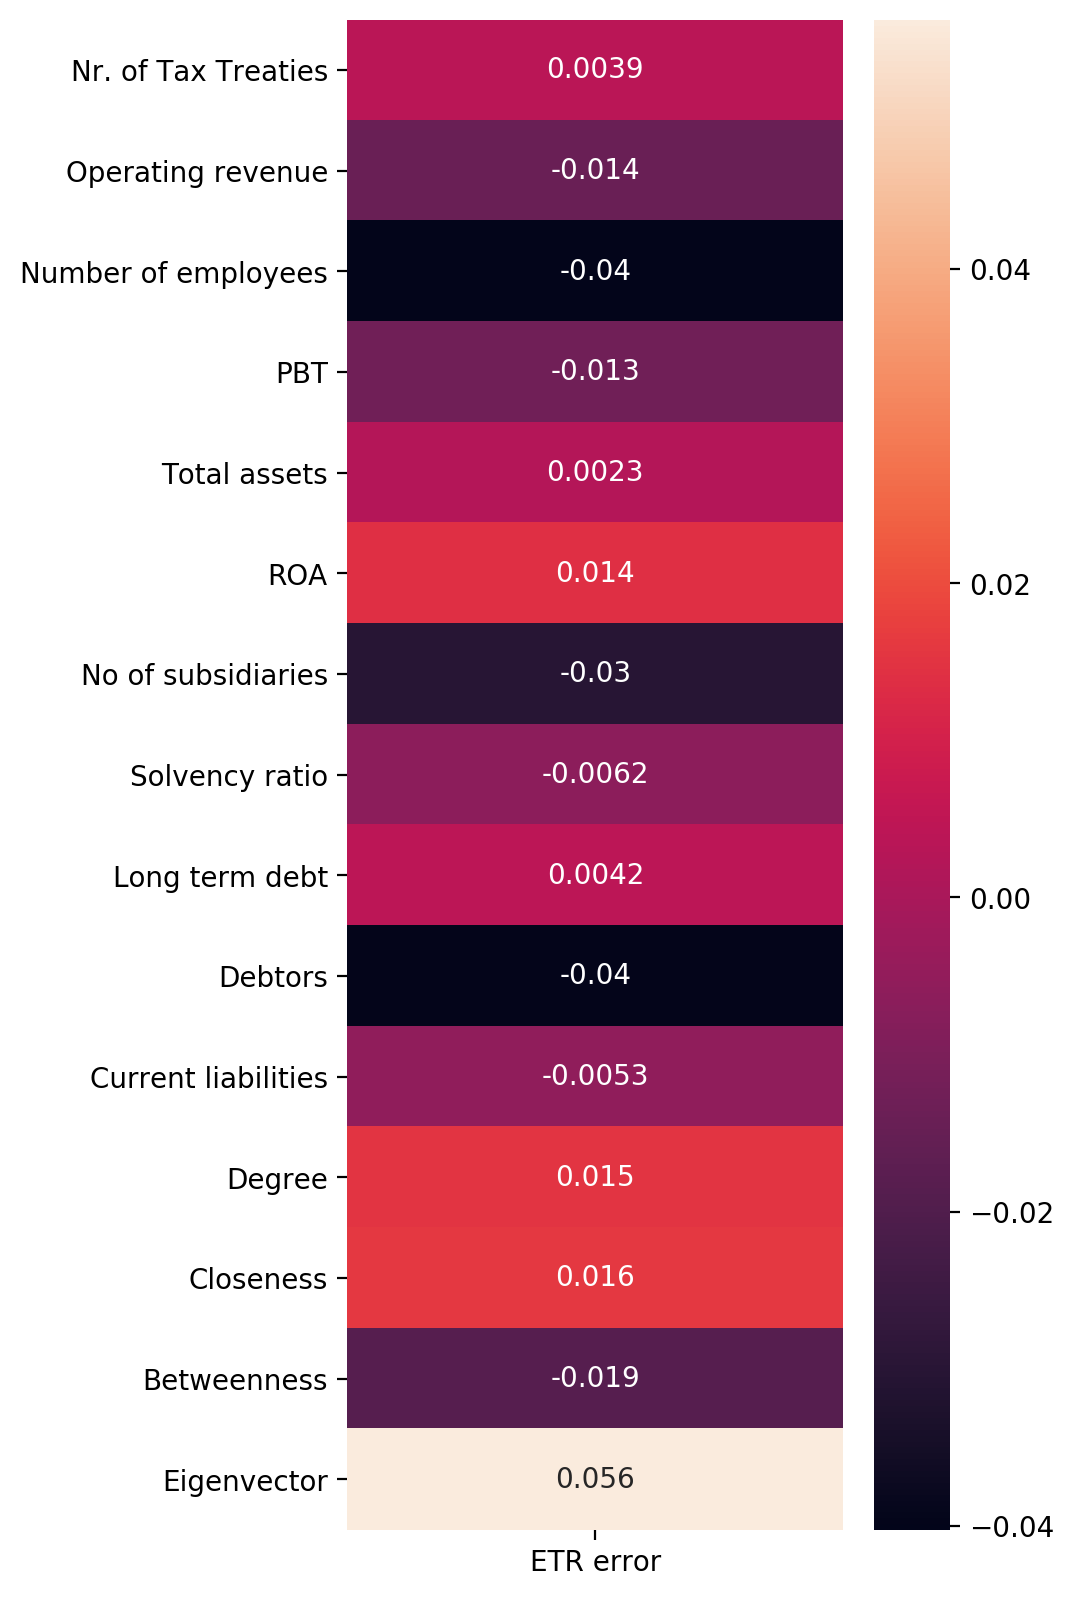

In [50]:
from matplotlib.pyplot import figure
y_error = pd.DataFrame(data = [(y_pred_winsor2-y_test_final_winsor2)]).T
y_error = pd.concat([X_test_winsor2, y_error], axis = 1)

cormat = y_error.corr()
round(cormat,3)

ETR_heatmap = cormat['ETR']
ETR_heatmap = pd.DataFrame(ETR_heatmap)
ETR_heatmap.rename(columns = {'ETR':'ETR error'}, inplace = True)
ETR_heatmap = ETR_heatmap.drop('ETR')

figure(figsize=(4, 10), dpi=200)
sns.heatmap(ETR_heatmap, annot = True)

In [44]:
ETR_heatmap.sort_values('ETR error')

,ETR error
NACE Rev. 2_4.0,-0.041613
Debtors,-0.039647
Number of employees,-0.032642
No of subsidiaries,-0.030417
Accounting practice_IFRS,-0.027047
Betweenness,-0.018752
NACE Rev. 2_6.0,-0.018578
Size_Small company,-0.016959
Operating revenue,-0.014009
PBT,-0.012771


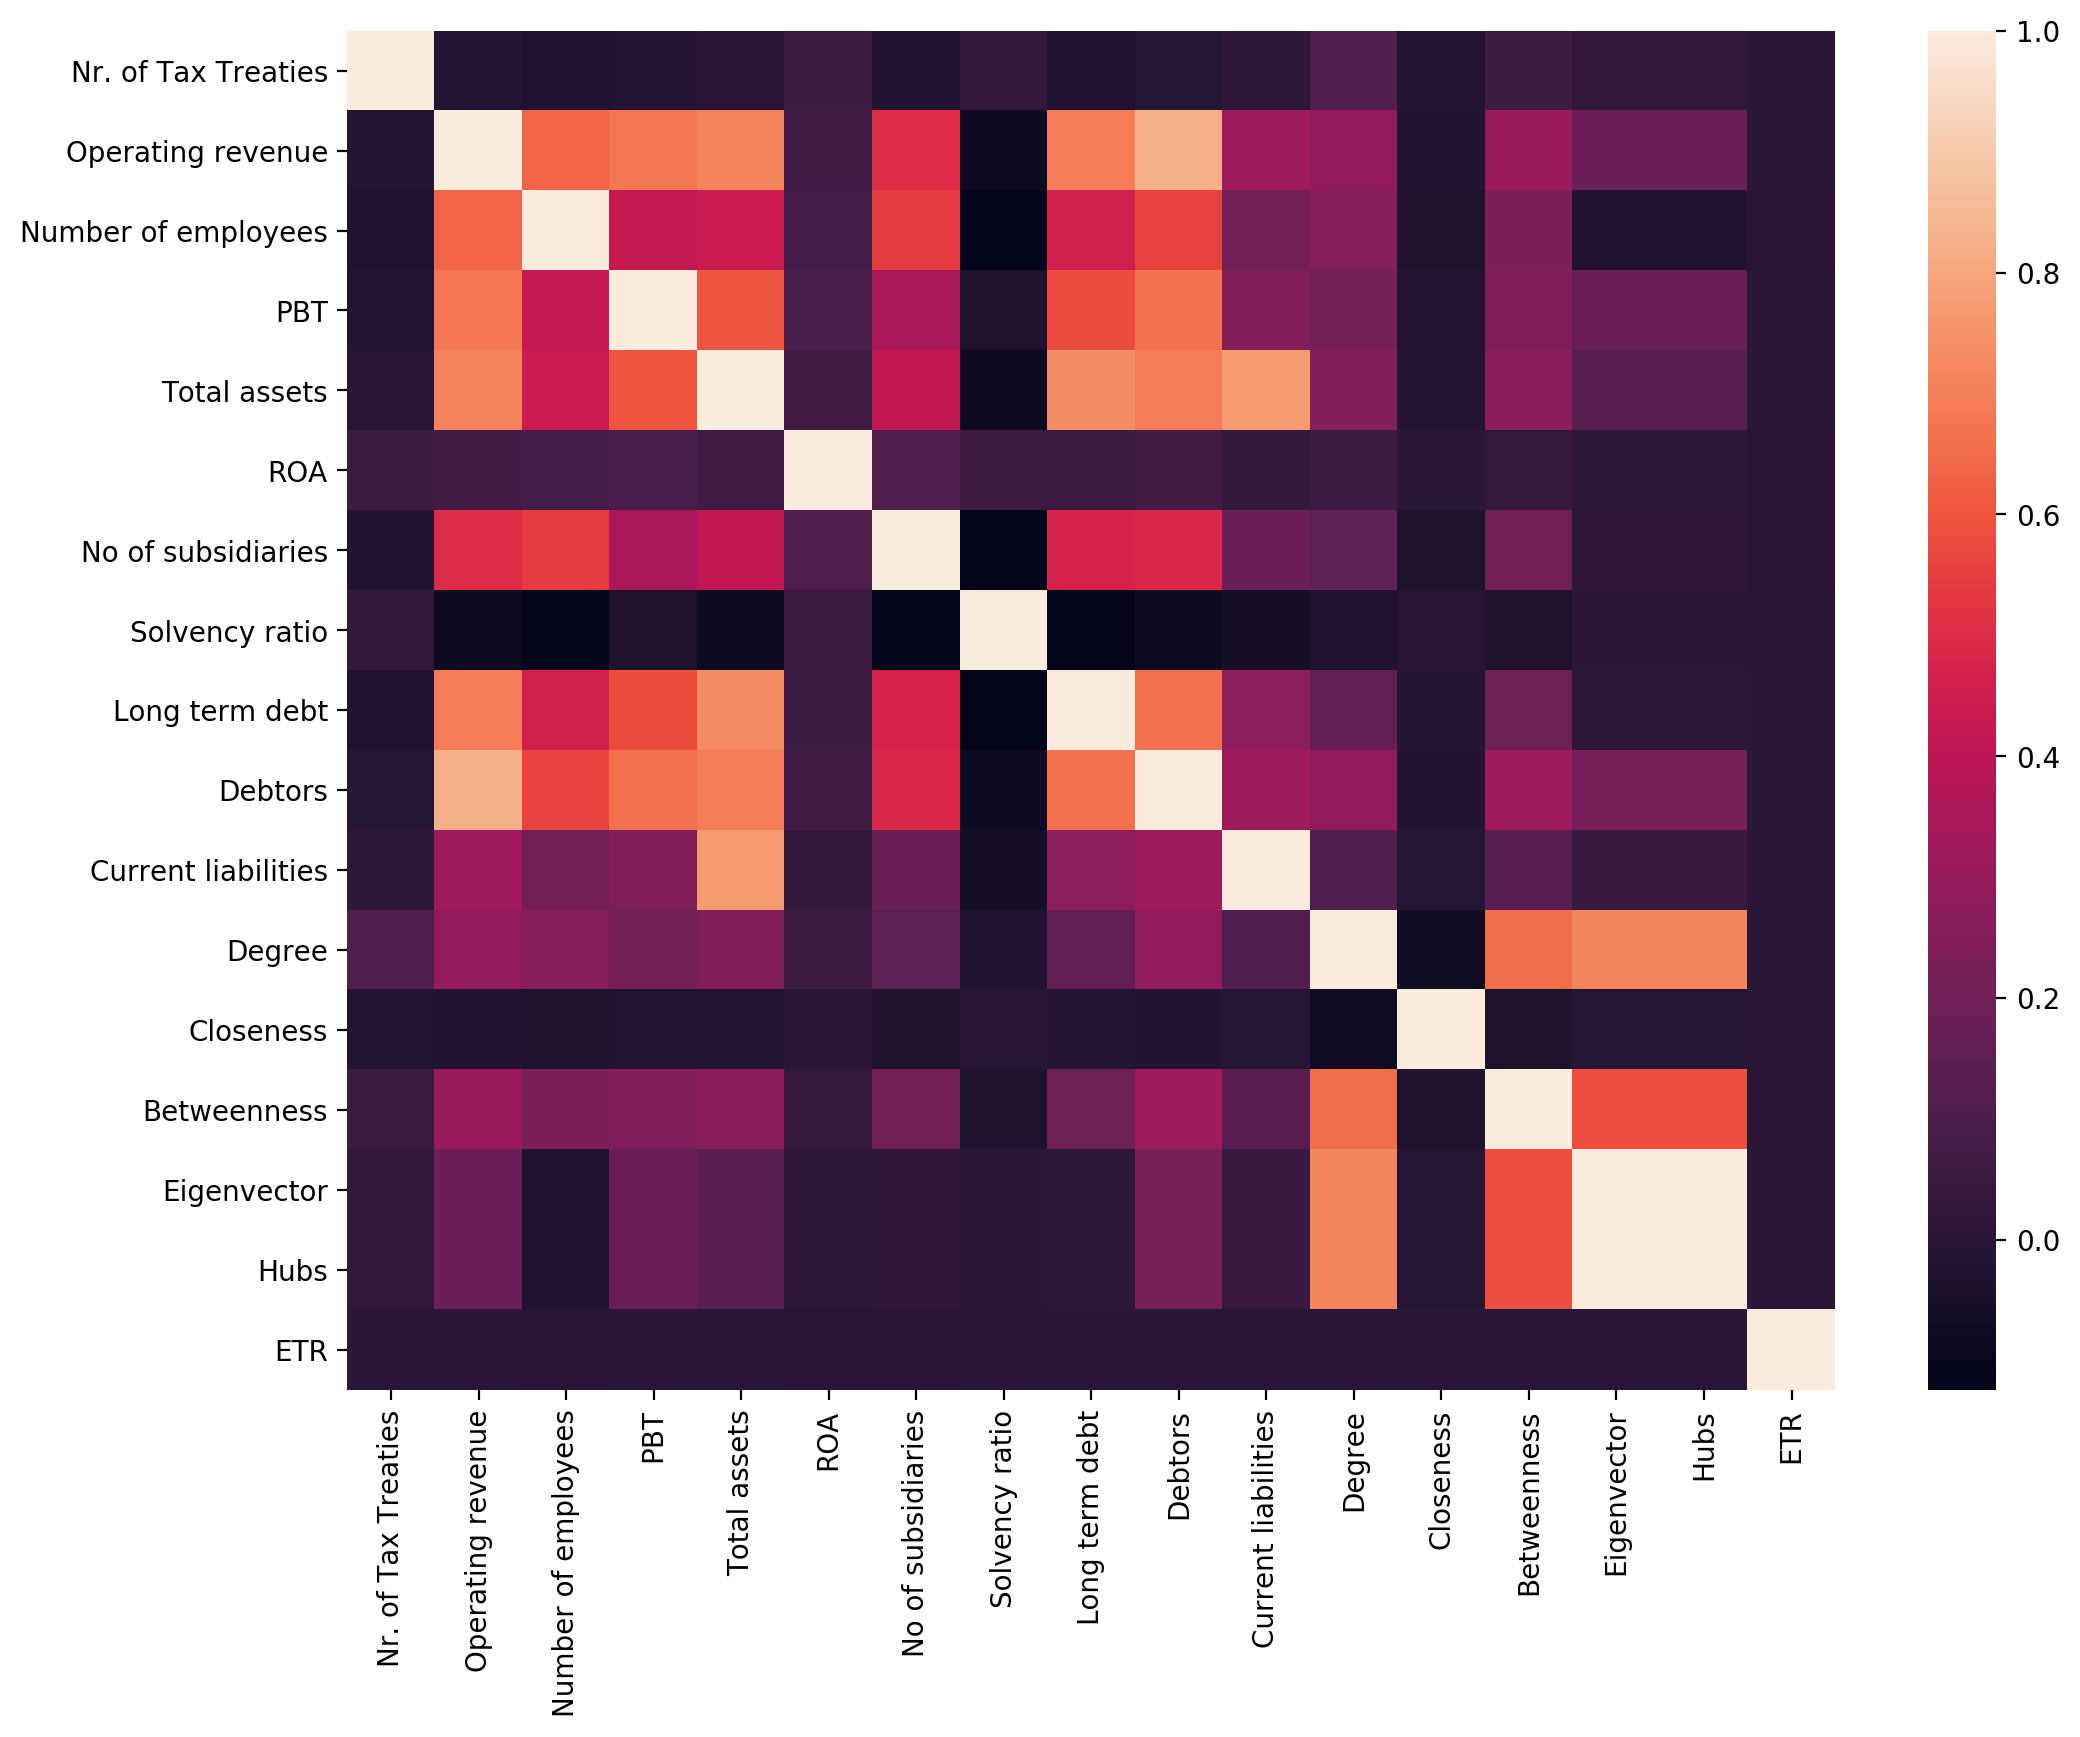

In [61]:
from matplotlib.pyplot import figure
X = data[["Nr. of Tax Treaties","NACE Rev. 2","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities", "Size","Accounting practice","Degree","Closeness","Betweenness","Eigenvector","Hubs"]]
y = data["ETR"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 2031996, shuffle = True)

y_error = pd.concat([X_train, y_train], axis = 1)

cormat = y_error.corr()
round(cormat,3)

figure(figsize=(12, 9), dpi=200)
sns.heatmap(cormat)